<b> <font size="+2.5"> Validation of age-regulated genes across cell types
 </b> </font> <br>

Author: ASF <br>
Date: 2023-12-19

Replication dataset from Chatzinakos et al. 2023 https://ajp.psychiatryonline.org/doi/10.1176/appi.ajp.20220478 <br>
Differential expression analysis for age-regulated genes in replication (validation) dataset was performed by Dr. Chris Chatzinakos <br> <br>
Replication dataset from Galatro et al. 2017 - Microglia https://doi.org/10.1038/nn.4597 <br> <br>
Replication dataset from Krawczyk et al. 2022 - Astrocytes https://doi.org/10.1523/JNEUROSCI.0407-21.2021

# Load libraries

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(readr)
library(readxl)
library(cowplot)
library(qvalue)
library(viridis)
library(GeneOverlap)
library(qvalue)
})

# Read in discovery dataset

In [2]:
# Read in DE results from this study (Fröhlich et al)
celltypes <- c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3", "Exc_L3-5", "Exc_L4-6_1", "Exc_L4-6_2", "Exc_L4-6_3", 
               "Exc_L5-6_1", "Exc_L5-6_2", "Exc_L5-6_HTR2C", "In_PVALB_Ba", "In_PVALB_Ch", "In_LAMP5_1", "In_LAMP5_2",
               "In_RELN", "In_SST", "In_VIP", "Microglia", "Oligodendrocyte", "OPC")

# Age effect
DE_genes_discovery <- list()
for (celltype in celltypes){
  tmp <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_20231121.xlsx', sheet = celltype))
  #rename 'ID' to 'genes'
  tmp <- rename(tmp,c('genes'='ID'))
  DE_genes_discovery[[celltype]] <- tmp
}

# read in DE results from major celltype
DE_genes_discovery[['Astrocytes']] <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_major_celltypes_20231123.xlsx', sheet = 'Astrocytes'))


# filter for significant hits
DE_genes_discovery_sig <- list()
for (celltype in names(DE_genes_discovery)){
  DE_genes_discovery_sig[[celltype]] <- DE_genes_discovery[[celltype]][DE_genes_discovery[[celltype]]$adj.P.Val < 0.05,]
}

# Validation

## Astrocytes

In [3]:
# read in results from validation dataset (Astrocytes)
# https://www.jneurosci.org/content/42/8/1587  Krawczyk et al. 2022
# only the significant genes are provided 

Astrocytes <- read_excel("../external_datasets/Krawczyk_et_al._Suppl_inline-supplementary-material-12.xlsx", skip = 1)

Astrocytes_up <- dplyr::filter(Astrocytes, `log2(Fold Change)` > 0)
Astrocytes_down <- dplyr::filter(Astrocytes, `log2(Fold Change)` < 0)

In [4]:
Astro_DE_up <- dplyr::filter(DE_genes_discovery_sig[['Astrocytes']], logFC > 0)
Astro_DE_down <- dplyr::filter(DE_genes_discovery_sig[['Astrocytes']], logFC < 0)

# filter out genes not expressed in my dataset from Galatro dataset then perform overlap
up_Krawczyk_filtered <- Astrocytes_up[Astrocytes_up$`Gene Name` %in% intersect(Astrocytes_up$`Gene Name`,DE_genes_discovery[['Astrocytes']]$ID),]
down_Krawczyk_filtered <- Astrocytes_down[Astrocytes_down$`Gene Name`%in% intersect(Astrocytes_down$`Gene Name`, DE_genes_discovery[['Astrocytes']]$ID),]

### GeneOverlap (Fisher's exact test)

In [5]:
# perform overlap
overlap_up_filtered <-  newGeneOverlap(Astro_DE_up$ID, up_Krawczyk_filtered$`Gene Name`, genome.size=length(DE_genes_discovery[['Astrocytes']]$ID))

overlap_stats_up_filtered <- testGeneOverlap(overlap_up_filtered)

Astrocytes_overlap_test_up_table <- as.data.frame(matrix(ncol=8, nrow=1))
colnames(Astrocytes_overlap_test_up_table) <- c('celltype_discovery', 'celltype_replication', 'Age DE genes discovery', 
                                               'Age DE genes replication', 'n overlap genes', 'Genome size', 'overlap p-value', 'Odds Ratio' )

Astrocytes_overlap_test_up_table$celltype_discovery <- 'Astrocytes'
Astrocytes_overlap_test_up_table$celltype_replication <- 'Astrocytes'
Astrocytes_overlap_test_up_table$`Age DE genes discovery` <- length(overlap_stats_up_filtered@listA)
Astrocytes_overlap_test_up_table$`Age DE genes replication` <- length(overlap_stats_up_filtered@listB)
Astrocytes_overlap_test_up_table$`n overlap genes` <- length(overlap_stats_up_filtered@intersection)
Astrocytes_overlap_test_up_table$`Genome size` <- overlap_stats_up_filtered@genome.size
Astrocytes_overlap_test_up_table$`overlap p-value` <- overlap_stats_up_filtered@pval
Astrocytes_overlap_test_up_table$`Odds Ratio` <- overlap_stats_up_filtered@odds.ratio

# perform overlap
overlap_down_filtered <-  newGeneOverlap(Astro_DE_down$ID, down_Krawczyk_filtered$`Gene Name`, genome.size=length(DE_genes_discovery[['Astrocytes']]$ID))

overlap_stats_down_filtered <- testGeneOverlap(overlap_down_filtered)

Astrocytes_overlap_test_down_table <- as.data.frame(matrix(ncol=8, nrow=1))
colnames(Astrocytes_overlap_test_down_table) <- c('celltype_discovery', 'celltype_replication', 'Age DE genes discovery', 
                                               'Age DE genes replication', 'n overlap genes', 'Genome size', 'overlap p-value', 'Odds Ratio' )

Astrocytes_overlap_test_down_table$celltype_discovery <- 'Astrocytes'
Astrocytes_overlap_test_down_table$celltype_replication <- 'Astrocytes'
Astrocytes_overlap_test_down_table$`Age DE genes discovery` <- length(overlap_stats_down_filtered@listA)
Astrocytes_overlap_test_down_table$`Age DE genes replication` <- length(overlap_stats_down_filtered@listB)
Astrocytes_overlap_test_down_table$`n overlap genes` <- length(overlap_stats_down_filtered@intersection)
Astrocytes_overlap_test_down_table$`Genome size` <- overlap_stats_down_filtered@genome.size
Astrocytes_overlap_test_down_table$`overlap p-value` <- overlap_stats_down_filtered@pval
Astrocytes_overlap_test_down_table$`Odds Ratio` <- overlap_stats_down_filtered@odds.ratio

In [6]:
Astrocytes_overlap_test_down_table

celltype_discovery,celltype_replication,Age DE genes discovery,Age DE genes replication,n overlap genes,Genome size,overlap p-value,Odds Ratio
<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
Astrocytes,Astrocytes,176,95,18,11401,4.090672e-15,16.47788


### Correlation of logFCs of overlapping genes

In [7]:
# Astrocytes
Astrocytes$ID <- Astrocytes$`Gene Name`

astrocytes_spearman <- as.data.frame(matrix(ncol=5, nrow=1))
colnames(astrocytes_spearman) <- c('celltype_discovery', 'celltype_replication', 'n_genes',
                                              'Rho', 'p-val')
tmp <- merge(DE_genes_discovery_sig[['Astrocytes']], Astrocytes, by='ID')
names(tmp)[names(tmp) == 'logFC'] <- 'logFC_discovery'
names(tmp)[names(tmp) == 'log2(Fold Change)'] <- 'logFC_replication'
tmp2 <- cor.test(tmp$logFC_discovery,tmp$logFC_replication,  method = "spearman")
astrocytes_spearman$celltype_discovery <- 'Astrocytes'
astrocytes_spearman$celltype_replication <- 'Astrocytes'
astrocytes_spearman$n_genes <- length(tmp$ID)
astrocytes_spearman$Rho <- tmp2$estimate
astrocytes_spearman$`p-val` <-tmp2$p.value

In [8]:
astrocytes_spearman

celltype_discovery,celltype_replication,n_genes,Rho,p-val
<chr>,<chr>,<int>,<dbl>,<dbl>
Astrocytes,Astrocytes,20,0.6947368,0.0009418302


## Microglia

In [9]:
# read in DE genes from validation dataset
# https://www.nature.com/articles/nn.4597#MOESM9 Galatro et al. 2017
# only significant genes are provided and not full DE results
up_Galatro <- read_excel("../external_datasets/Galatro_et_al._41593_2017_BFnn4597_MOESM9_ESM.xlsx", sheet = 'age_up')
down_Galatro <- read_excel("../external_datasets/Galatro_et_al._41593_2017_BFnn4597_MOESM9_ESM.xlsx", sheet = 'age_down')

In [10]:
# split the DE genes in up- & downregulated
up_DE_Age <- dplyr::filter(DE_genes_discovery_sig[['Microglia']], logFC > 0)
down_DE_Age <- dplyr::filter(DE_genes_discovery_sig[['Microglia']], logFC < 0)

# filter out genes not expressed in my dataset from Galatro dataset then perform overlap
up_Galatro_filtered <- up_Galatro[up_Galatro$external_gene_name %in% intersect(up_Galatro$external_gene_name, DE_genes_discovery[['Microglia']]$genes),]
down_Galatro_filtered <- down_Galatro[down_Galatro$external_gene_name %in% intersect(down_Galatro$external_gene_name, DE_genes_discovery[['Microglia']]$genes),]

### GeneOverlap (Fisher's exact test)

In [11]:
# perform overlap for upregulated genes
overlap_up_filtered <-  newGeneOverlap(up_DE_Age$genes,up_Galatro_filtered$external_gene_name, genome.size=length(DE_genes_discovery[['Microglia']]$genes))
overlap_stats_up_filtered <- testGeneOverlap(overlap_up_filtered)

Microglia_overlap_test_up_table <- as.data.frame(matrix(ncol=8, nrow=1))
colnames(Microglia_overlap_test_up_table) <- c('celltype_discovery', 'celltype_replication', 'Age DE genes discovery', 
                                               'Age DE genes replication', 'n overlap genes', 
                                               'Genome size', 'overlap p-value', 'Odds Ratio' )

Microglia_overlap_test_up_table$celltype_discovery <- 'Microglia'
Microglia_overlap_test_up_table$celltype_replication <- 'Microglia'
Microglia_overlap_test_up_table$`Age DE genes discovery` <- length(overlap_stats_up_filtered@listA)
Microglia_overlap_test_up_table$`Age DE genes replication` <- length(overlap_stats_up_filtered@listB)
Microglia_overlap_test_up_table$`n overlap genes` <- length(overlap_stats_up_filtered@intersection)
Microglia_overlap_test_up_table$`Genome size` <- overlap_stats_up_filtered@genome.size
Microglia_overlap_test_up_table$`overlap p-value` <- overlap_stats_up_filtered@pval
Microglia_overlap_test_up_table$`Odds Ratio` <- overlap_stats_up_filtered@odds.ratio

# perform overlap for downregulated genes
overlap_down_filtered <-  newGeneOverlap(down_DE_Age$genes,down_Galatro_filtered$external_gene_name, genome.size=length(DE_genes_discovery[['Microglia']]$genes))
overlap_stats_down_filtered <- testGeneOverlap(overlap_down_filtered)

Microglia_overlap_test_down_table <- as.data.frame(matrix(ncol=8, nrow=1))
colnames(Microglia_overlap_test_down_table) <- c('celltype_discovery', 'celltype_replication', 'Age DE genes discovery', 
                                               'Age DE genes replication', 'n overlap genes', 
                                               'Genome size', 'overlap p-value', 'Odds Ratio' )

Microglia_overlap_test_down_table$celltype_discovery <- 'Microglia'
Microglia_overlap_test_down_table$celltype_replication <- 'Microglia'
Microglia_overlap_test_down_table$`Age DE genes discovery` <- length(overlap_stats_down_filtered@listA)
Microglia_overlap_test_down_table$`Age DE genes replication` <- length(overlap_stats_down_filtered@listB)
Microglia_overlap_test_down_table$`n overlap genes` <- length(overlap_stats_down_filtered@intersection)
Microglia_overlap_test_down_table$`Genome size` <- overlap_stats_down_filtered@genome.size
Microglia_overlap_test_down_table$`overlap p-value` <- overlap_stats_down_filtered@pval
Microglia_overlap_test_down_table$`Odds Ratio` <- overlap_stats_down_filtered@odds.ratio

### Correlation of logFCs of overlapping genes

In [12]:
#Microglia
names(down_Galatro)[names(down_Galatro) == 'ensemble_gene_id'] <- 'ensembl_gene_id'
Mic_Galatro <- rbind(down_Galatro, up_Galatro)
Mic_Galatro$genes <- Mic_Galatro$external_gene_name

In [13]:
microglia_spearman <- as.data.frame(matrix(ncol=5, nrow=1))
colnames(microglia_spearman) <- c('celltype_discovery', 'celltype_replication', 'n_genes',
                                              'Rho', 'p-val')
tmp <- merge(DE_genes_discovery_sig[['Microglia']], Mic_Galatro, by='genes')
names(tmp)[names(tmp) == 'logFC.x'] <- 'logFC_discovery'
names(tmp)[names(tmp) == 'logFC.y'] <- 'logFC_replication'
tmp2 <- cor.test(tmp$logFC_discovery,tmp$logFC_replication,  method = "spearman")
microglia_spearman$celltype_discovery <- 'Microglia'
microglia_spearman$celltype_replication <- 'Microglia'
microglia_spearman$n_genes <- length(tmp$genes)
microglia_spearman$Rho <- tmp2$estimate
microglia_spearman$`p-val` <-tmp2$p.value

In [14]:
microglia_spearman

celltype_discovery,celltype_replication,n_genes,Rho,p-val
<chr>,<chr>,<int>,<dbl>,<dbl>
Microglia,Microglia,18,0.9153767,0


## Excitatory and Inhibitory Neurons

In [15]:
# Read in results from validation dataset (Chatzinakos et al. 2023) and format
Chatzinakos_et_al <- read.csv('../external_datasets/AJP_SC_Res_AGE_ALL_cluster.csv')
#head(Chatzinakos_et_al)

DE_genes_replication <- list()
for (cluster in unique(Chatzinakos_et_al$cluster)){
  DE_genes_replication[[cluster]] <- Chatzinakos_et_al[Chatzinakos_et_al$cluster == cluster,]
  DE_genes_replication[[cluster]]$celltype <- str_extract(DE_genes_replication[[cluster]]$cluster, "(?<=32SC_Res_AGE_).*(?=_cluster)")
}
names(DE_genes_replication) <- str_extract(names(DE_genes_replication), "(?<=32SC_Res_AGE_).*(?=_cluster)")
head(DE_genes_replication[['In1c_VIP']])

,logFC,AveExpr,t,P.Value,adj.P.Val,B,genes,cluster,celltype
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
190464,-0.08773798,1.507368,-5.880830,8.093517e-06,0.1182516,3.523547,RPS17,32SC_Res_AGE_In1c_VIP_cluster,In1c_VIP
190465,0.04620503,5.380270,5.381596,2.538285e-05,0.1182516,2.381315,ENOSF1,32SC_Res_AGE_In1c_VIP_cluster,In1c_VIP
190466,-0.03696392,5.066970,-5.310321,2.994348e-05,0.1182516,2.216440,RAB3B,32SC_Res_AGE_In1c_VIP_cluster,In1c_VIP
190467,-0.03681491,4.047320,-5.280123,3.211944e-05,0.1182516,2.146467,PSMG1,32SC_Res_AGE_In1c_VIP_cluster,In1c_VIP
190468,0.03737819,3.105476,5.225364,3.648390e-05,0.1182516,2.019415,KDELC2,32SC_Res_AGE_In1c_VIP_cluster,In1c_VIP
190469,-0.06738522,3.818479,-5.017140,5.936168e-05,0.1223291,1.534483,TOMM22,32SC_Res_AGE_In1c_VIP_cluster,In1c_VIP


### Select cell types for validation

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwid

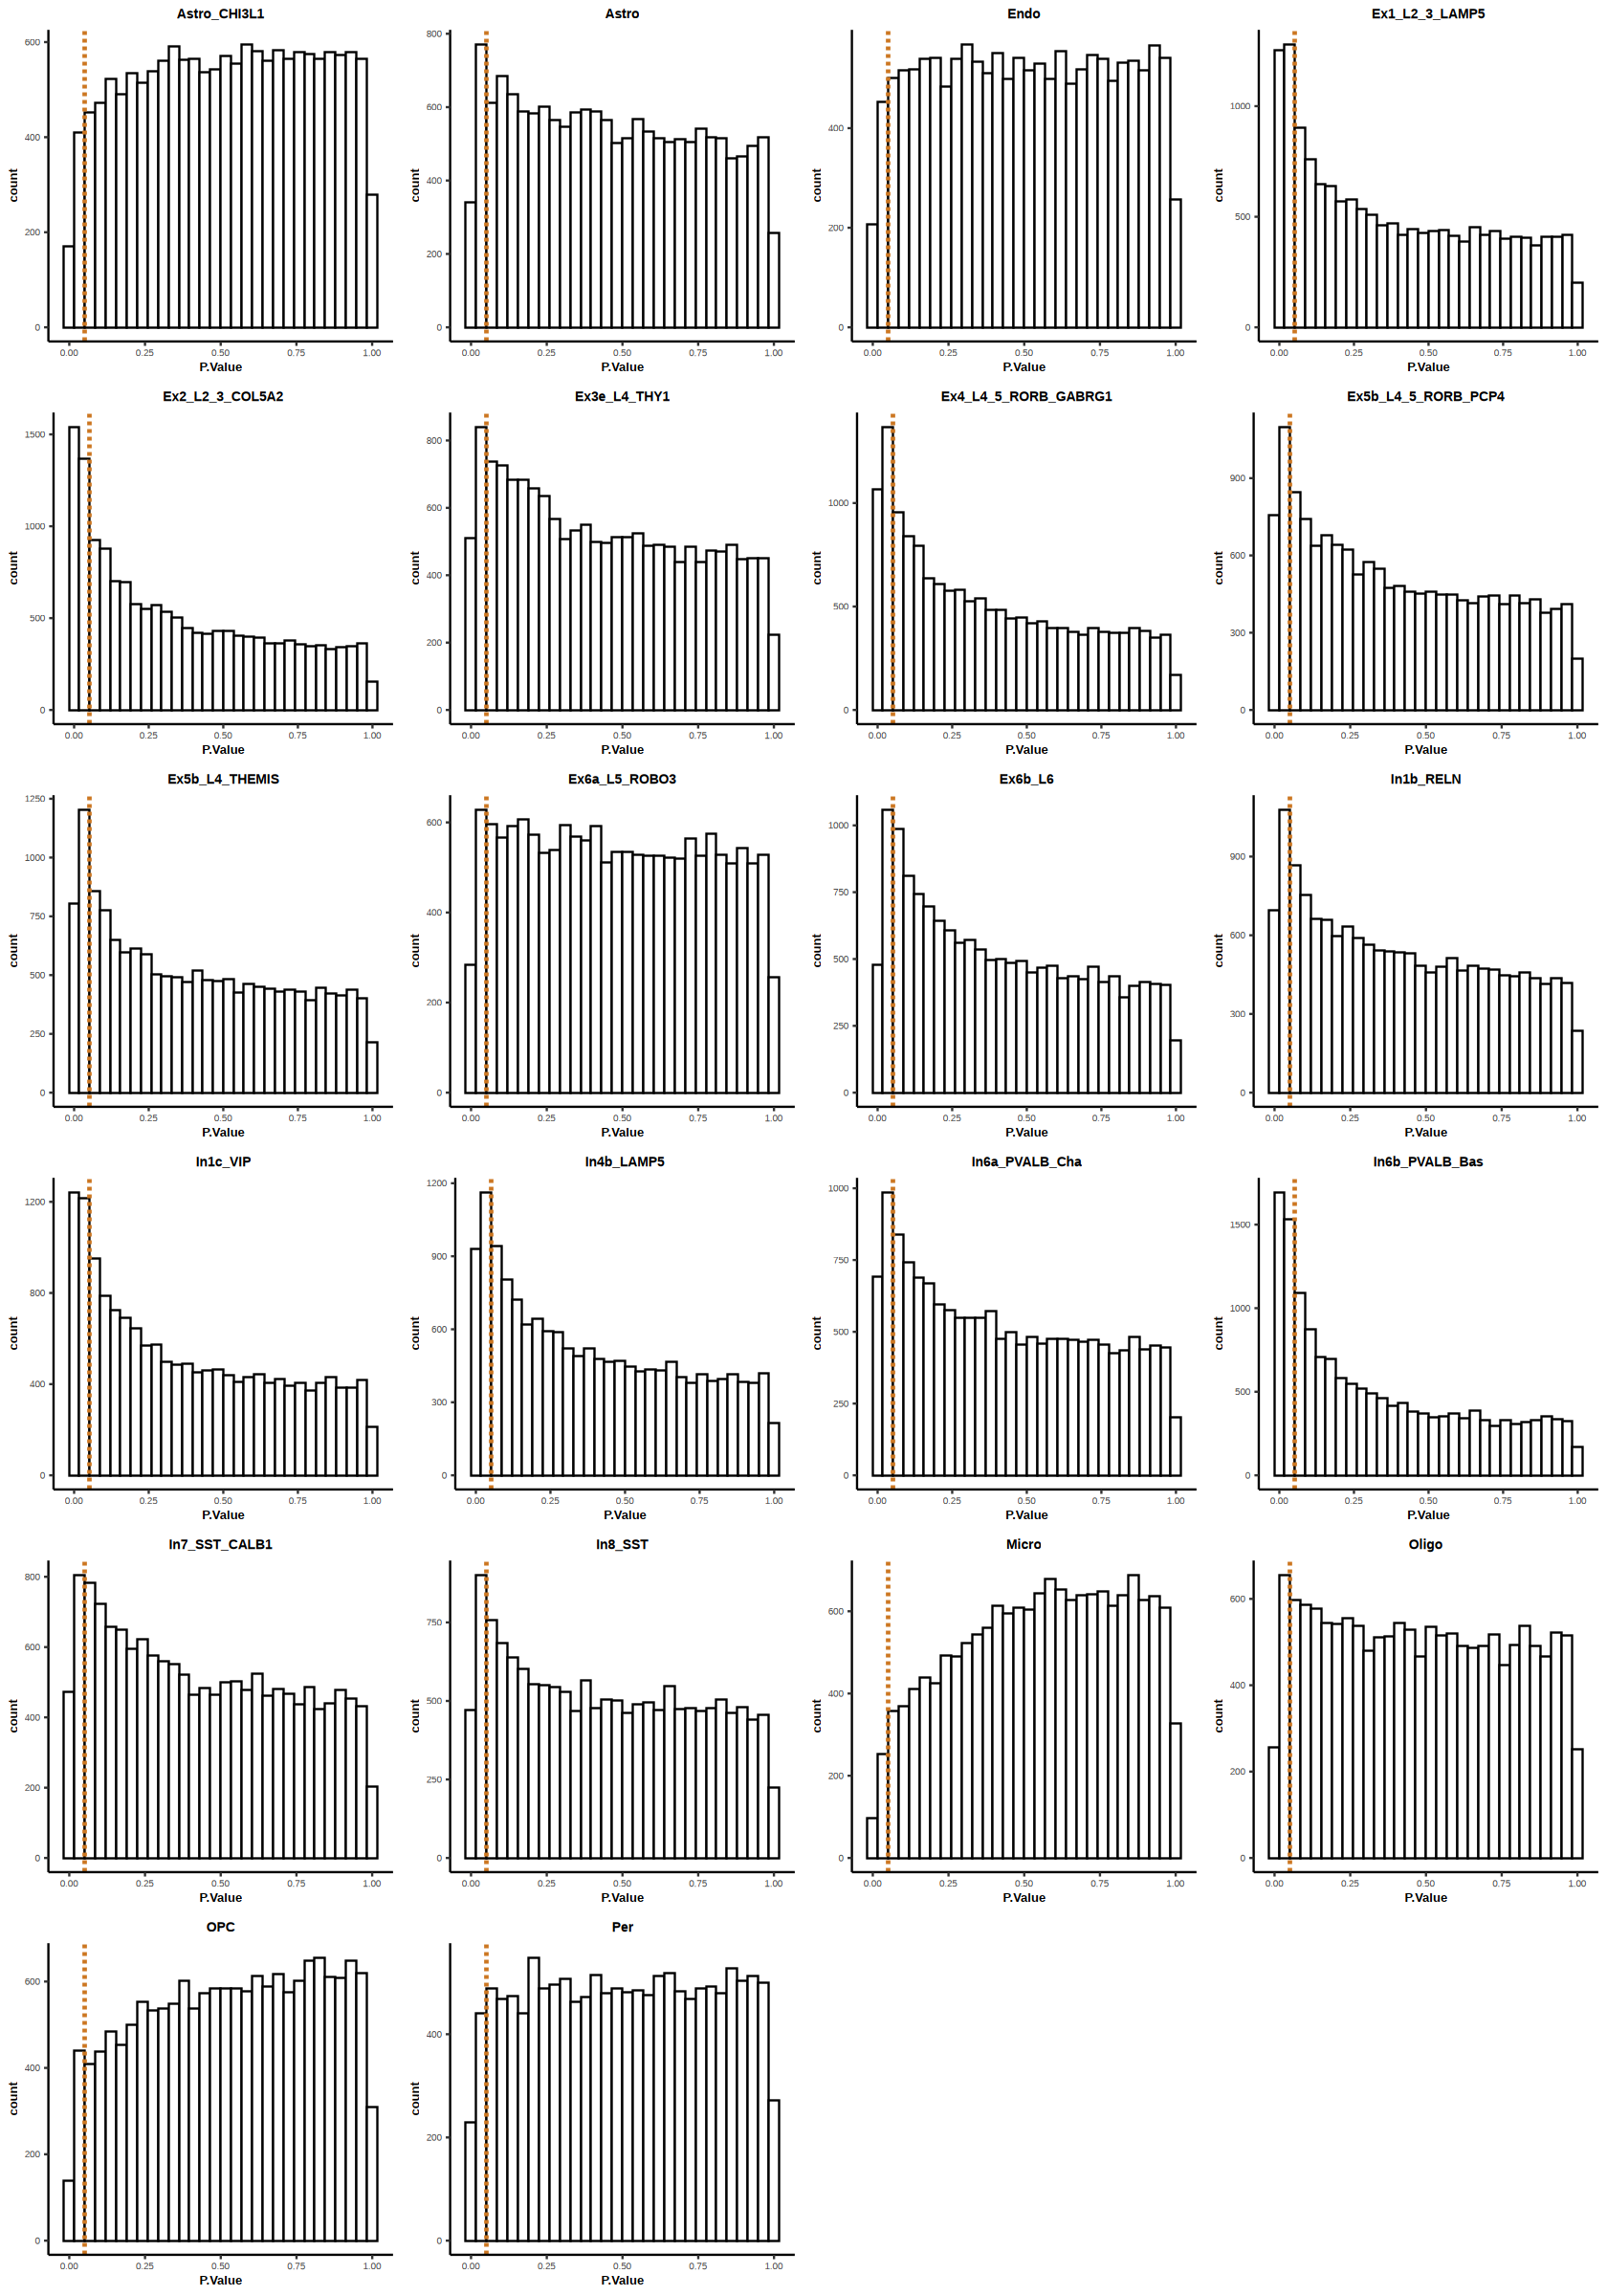

In [16]:
# check p-value distribution to identify cell types that show any age-related expression changes
# the dataset contained only N=32 individuals thus reduced power to detect changes
fig_list <- list()
for (celltype in names(DE_genes_replication)){
  fig_list[[celltype]] <- ggplot(DE_genes_replication[[celltype]], aes(x=P.Value)) + 
    geom_histogram(color="black", fill="white") +theme_classic() + ggtitle(celltype) + 
    theme(axis.title = element_text(face='bold', size=7.5), plot.title=element_text(face='bold', size=8, hjust=0.5), 
          axis.text=element_text(size=5.5)) +
    geom_vline(aes(xintercept = 0.05), colour="#CC7722", linetype="dashed", linewidth=1)}

options(repr.plot.width=14, repr.plot.height=20)
plot_grid(plotlist=fig_list, ncol=4)

#ggsave('../figures/Chatzinakos_et_al._p-val-distribution_hist_unadj_pval.pdf', plot = last_plot(), width = 7, height =10)

In [17]:
# select cell types for validation
p_val_percentile <- as.data.frame(matrix(ncol=2, nrow=length(names(DE_genes_replication))))
colnames(p_val_percentile) <- c('celltype', '15th_percentile')
p_val_percentile$celltype <- names(DE_genes_replication)
for (celltype in names(DE_genes_replication)){
  p_val_percentile[p_val_percentile$celltype ==celltype,]$`15th_percentile` <- quantile(DE_genes_replication[[celltype]]$P.Value, c(.15))}
#p_val_percentile

celltypes_with_effect <- p_val_percentile[p_val_percentile$`15th_percentile` < 0.1,]$celltype
celltypes_with_effect

[1] "Ex1_L2_3_LAMP5"       "Ex2_L2_3_COL5A2"      "Ex4_L4_5_RORB_GABRG1"
 [4] "Ex5b_L4_5_RORB_PCP4"  "Ex5b_L4_THEMIS"       "Ex6b_L6"             
 [7] "In1b_RELN"            "In1c_VIP"             "In4b_LAMP5"          
[10] "In6a_PVALB_Cha"       "In6b_PVALB_Bas"       "In7_SST_CALB1"       
[13] "In8_SST"

In [18]:
###
# Assign the corresponding cell types between the two datasets
###
#Ex1_L2_3_LAMP5 -> Exc_L2-3
#Ex2_L2_3_COL5A2 -> Exc_L2-3
#Ex4_L4_5_RORB_GABRG1 -> Exc_L4-6_2
#Ex5b_L4_5_RORB_PCP4 -> Exc_L4-6_1
#Ex5b_L4_THEMIS -> Exc_L4-6_3
#Ex6b_L6 -> Exc_L5-6_1
#In1b_RELN -> In_RELN
#In1c_VIP -> In_VIP
#In4b_LAMP5 -> In_LAMP5
#In6a_PVALB_Cha -> In_PVALB_Ch
#In6b_PVALB_Bas -> In_PVALB_Ba
#In7_SST_CALB1 -> In_SST
#In8_SST -> In_SST

# make a named vector containing corresponding cell type  
celltype_comparisons <- c('Exc_L2-3', 'Exc_L2-3', 'Exc_L4-6_1', 'Exc_L4-6_2', 'Exc_L4-6_3','Exc_L5-6_1', 'In_LAMP5_1', 'In_LAMP5_2', 'In_PVALB_Ba', 'In_PVALB_Ch', 'In_RELN', 'In_SST', 'In_SST','In_VIP' )
names(celltype_comparisons) <- c('Ex1_L2_3_LAMP5', 'Ex2_L2_3_COL5A2', 'Ex5b_L4_5_RORB_PCP4','Ex4_L4_5_RORB_GABRG1', 'Ex5b_L4_THEMIS', 'Ex6b_L6','In4b_LAMP5','In4b_LAMP5','In6b_PVALB_Bas', 'In6a_PVALB_Cha', 'In1b_RELN', 'In7_SST_CALB1', 'In8_SST', 'In1c_VIP' )

### GeneOverlap (Fisher's exact test)

In [19]:
# make a named vector containing corresponding cell type
# if cell type has two corresponding cell types, one will be marked with * (to have unique factors)
celltype_comparisons <- c('Exc_L2-3', 'Exc_L2-3*', 'Exc_L4-6_1', 'Exc_L4-6_2', 'Exc_L4-6_3','Exc_L5-6_1', 'In_LAMP5_1', 'In_LAMP5_2', 'In_PVALB_Ba', 'In_PVALB_Ch', 'In_RELN', 'In_SST', 'In_SST*','In_VIP' )
names(celltype_comparisons) <- c('Ex1_L2_3_LAMP5', 'Ex2_L2_3_COL5A2', 'Ex5b_L4_5_RORB_PCP4','Ex4_L4_5_RORB_GABRG1', 'Ex5b_L4_THEMIS', 'Ex6b_L6','In4b_LAMP5','In4b_LAMP5*','In6b_PVALB_Bas', 'In6a_PVALB_Cha', 'In1b_RELN', 'In7_SST_CALB1', 'In8_SST', 'In1c_VIP' )

# duplicated celltype with *
DE_genes_discovery[['Exc_L2-3*']] <- DE_genes_discovery[['Exc_L2-3']] 
DE_genes_discovery[['In_SST*']] <- DE_genes_discovery[['In_SST']] 

DE_genes_replication[['In4b_LAMP5*']] <- DE_genes_replication[['In4b_LAMP5']] 

In [20]:
# get signficant genes at adjusted p-value < 0.05
# split in up and downregulated
DE_genes_discovery_sig <- list()
DE_genes_discovery_sig_up <- list()
DE_genes_discovery_sig_down <- list()
for (celltype in names(DE_genes_discovery)){
    DE_genes_discovery_sig[[celltype]] <- DE_genes_discovery[[celltype]][DE_genes_discovery[[celltype]]$adj.P.Val < 0.05,]
    DE_genes_discovery_sig_up[[celltype]] <- DE_genes_discovery_sig[[celltype]][DE_genes_discovery_sig[[celltype]]$logFC > 0,]
    DE_genes_discovery_sig_down[[celltype]] <- DE_genes_discovery_sig[[celltype]][DE_genes_discovery_sig[[celltype]]$logFC <0,]
}

In [21]:
DE_genes_replication_sig <- list()
DE_genes_replication_sig_up <- list()
DE_genes_replication_sig_down <- list()
idx <- 0
for (celltype in 1:length(celltype_comparisons)){
    idx <- idx +1
    celltype_discovery <- celltype_comparisons[idx]
    celltype_replication <- names(celltype_comparisons)[idx]
    
    # filter replication dataset for genes with nominal p-value < 0.05
    DE_genes_replication_sig[[celltype_replication]] <- DE_genes_replication[[celltype_replication]][DE_genes_replication[[celltype_replication]]$P.Value < 0.05,]
    DE_genes_replication_sig_up[[celltype_replication]] <-  DE_genes_replication_sig[[celltype_replication]][DE_genes_replication_sig[[celltype_replication]]$logFC > 0,]
    DE_genes_replication_sig_down[[celltype_replication]] <-  DE_genes_replication_sig[[celltype_replication]][DE_genes_replication_sig[[celltype_replication]]$logFC < 0,]
    
    # filter out genes not expressed in discovery dataset
    DE_genes_replication_sig_up[[celltype_replication]] <- DE_genes_replication_sig_up[[celltype_replication]][DE_genes_replication_sig_up[[celltype_replication]]$genes 
                                                                                       %in% intersect(DE_genes_replication_sig_up[[celltype_replication]]$genes, 
                                                                                                      DE_genes_discovery[[celltype_discovery]]$genes),]
    DE_genes_replication_sig_down[[celltype_replication]] <- DE_genes_replication_sig_down[[celltype_replication]][DE_genes_replication_sig_down[[celltype_replication]]$genes 
                                                                                       %in% intersect(DE_genes_replication_sig_down[[celltype_replication]]$genes, 
                                                                                                      DE_genes_discovery[[celltype_discovery]]$genes),]
    
}

In [22]:
# perform overlap for upregulated genes
overlap_up <-  list()

overlap_test_up_table <- as.data.frame(matrix(ncol=8, nrow=length(celltype_comparisons)))
colnames(overlap_test_up_table) <- c('celltype_discovery', 'celltype_replication', 'Age DE genes discovery', 
                                               'Age DE genes replication', 'n overlap genes', 
                                               'Genome size', 'overlap p-value', 'Odds Ratio' )

idx <- 0
for (celltype in 1:length(celltype_comparisons)){
    idx <- idx +1
    celltype_discovery <- celltype_comparisons[idx]
    celltype_replication <- names(celltype_comparisons)[idx]
    tmp <- newGeneOverlap(DE_genes_discovery_sig_up[[celltype_discovery]]$genes,
                          DE_genes_replication_sig_up[[celltype_replication]]$genes, 
                          genome.size=length(DE_genes_discovery[[celltype_discovery]]$genes))
    overlap_stats_up <- testGeneOverlap(tmp)
    overlap_test_up_table$`celltype_discovery`[idx] <- celltype_discovery
    overlap_test_up_table$`celltype_replication`[idx] <- celltype_replication
    overlap_test_up_table$`Age DE genes discovery`[idx] <- length(overlap_stats_up@listA)
    overlap_test_up_table$`Age DE genes replication`[idx] <- length(overlap_stats_up@listB)
    overlap_test_up_table$`n overlap genes`[idx] <- length(overlap_stats_up@intersection)
    overlap_test_up_table$`Genome size`[idx] <- overlap_stats_up@genome.size
    overlap_test_up_table$`overlap p-value`[idx] <- overlap_stats_up@pval
    overlap_test_up_table$`Odds Ratio`[idx] <- overlap_stats_up@odds.ratio
}


# perform overlap for downregulated genes
overlap_down <-  list()

overlap_test_down_table <- as.data.frame(matrix(ncol=8, nrow=length(celltype_comparisons)))
colnames(overlap_test_down_table) <- c('celltype_discovery', 'celltype_replication', 'Age DE genes discovery', 
                                               'Age DE genes replication', 'n overlap genes', 
                                               'Genome size', 'overlap p-value', 'Odds Ratio' )

idx <- 0
for (celltype in 1:length(celltype_comparisons)){
    idx <- idx +1
    celltype_discovery <- celltype_comparisons[idx]
    celltype_replication <- names(celltype_comparisons)[idx]
    tmp <- newGeneOverlap(DE_genes_discovery_sig_down[[celltype_discovery]]$genes,
                          DE_genes_replication_sig_down[[celltype_replication]]$genes, 
                          genome.size=length(DE_genes_discovery[[celltype_discovery]]$genes))
    overlap_stats_down <- testGeneOverlap(tmp)
    overlap_test_down_table$`celltype_discovery`[idx] <- celltype_discovery
    overlap_test_down_table$`celltype_replication`[idx] <- celltype_replication
    overlap_test_down_table$`Age DE genes discovery`[idx] <- length(overlap_stats_down@listA)
    overlap_test_down_table$`Age DE genes replication`[idx] <- length(overlap_stats_down@listB)
    overlap_test_down_table$`n overlap genes`[idx] <- length(overlap_stats_down@intersection)
    overlap_test_down_table$`Genome size`[idx] <- overlap_stats_down@genome.size
    overlap_test_down_table$`overlap p-value`[idx] <- overlap_stats_down@pval
    overlap_test_down_table$`Odds Ratio`[idx] <- overlap_stats_down@odds.ratio
}

### Correlation of logFCs of overlapping genes

In [23]:
#Calculate spearman correlation
discovery_replication_spearman <- as.data.frame(matrix(ncol=5, nrow=length(names(celltype_comparisons))))
colnames(discovery_replication_spearman) <- c('celltype_discovery', 'celltype_replication', 'n_genes',
                                              'Rho', 'p-val')

idx <- 0
for (celltype in 1:length(celltype_comparisons)){
    idx <- idx +1
    celltype_discovery <- celltype_comparisons[idx]
    celltype_replication <- names(celltype_comparisons)[idx]
    tmp <- merge(DE_genes_discovery_sig[[celltype_discovery]], DE_genes_replication_sig[[celltype_replication]], by='genes')
    names(tmp)[names(tmp) == 'logFC.x'] <- 'logFC_discovery'
    names(tmp)[names(tmp) == 'logFC.y'] <- 'logFC_replication'
    tmp2 <- cor.test(tmp$logFC_discovery,tmp$logFC_replication,  method = "spearman")
    discovery_replication_spearman$celltype_discovery[idx] <- celltype_discovery
    discovery_replication_spearman$celltype_replication[idx] <- celltype_replication
    discovery_replication_spearman$n_genes[idx] <- length(tmp$genes)
    discovery_replication_spearman$Rho[idx] <- tmp2$estimate
    discovery_replication_spearman$`p-val`[idx] <- tmp2$p.value
}
View(discovery_replication_spearman)

celltype_discovery,celltype_replication,n_genes,Rho,p-val
<chr>,<chr>,<int>,<dbl>,<dbl>
Exc_L2-3,Ex1_L2_3_LAMP5,312,0.7818325,0.000000e+00
Exc_L2-3*,Ex2_L2_3_COL5A2,341,0.8070865,0.000000e+00
Exc_L4-6_1,Ex5b_L4_5_RORB_PCP4,161,0.8296210,0.000000e+00
Exc_L4-6_2,Ex4_L4_5_RORB_GABRG1,199,0.8492188,0.000000e+00
Exc_L4-6_3,Ex5b_L4_THEMIS,43,0.8057989,0.000000e+00
Exc_L5-6_1,Ex6b_L6,16,0.7235294,2.173821e-03
In_LAMP5_1,In4b_LAMP5,71,0.6110329,3.181339e-08
In_LAMP5_2,In4b_LAMP5*,98,0.6474189,0.000000e+00
In_PVALB_Ba,In6b_PVALB_Bas,56,0.7765550,0.000000e+00


# Fig. 5a

## Odds Ratio (Fisher's exact test)

In [24]:
# merge the overlap results from the different celltypes (from different studies)
overlap_test_up_table_final <- rbind(Astrocytes_overlap_test_up_table, Microglia_overlap_test_up_table, overlap_test_up_table)
overlap_test_down_table_final <- rbind(Astrocytes_overlap_test_down_table, Microglia_overlap_test_down_table, overlap_test_down_table)

overlap_test_up_table_final$adj.P.Val <- p.adjust(overlap_test_up_table_final$`overlap p-value`, method='fdr', n=length(overlap_test_up_table_final$`overlap p-value`))
overlap_test_down_table_final$adj.P.Val <- p.adjust(overlap_test_down_table_final$`overlap p-value`, method='fdr', n=length(overlap_test_down_table_final$`overlap p-value`))

levels_discovery <- as.factor(c('Astrocytes', 'Microglia','Exc_L2-3', 'Exc_L2-3*', 'Exc_L4-6_1', 'Exc_L4-6_2', 'Exc_L4-6_3','Exc_L5-6_1', 'In_LAMP5_1', 'In_LAMP5_2', 'In_PVALB_Ba', 'In_PVALB_Ch', 'In_RELN', 'In_SST', 'In_SST*','In_VIP'))
levels_replication <- as.factor(c('Astrocytes', 'Microglia', 'Ex1_L2_3_LAMP5', 'Ex2_L2_3_COL5A2', 'Ex5b_L4_5_RORB_PCP4','Ex4_L4_5_RORB_GABRG1', 'Ex5b_L4_THEMIS', 'Ex6b_L6','In4b_LAMP5','In4b_LAMP5*','In6b_PVALB_Bas', 'In6a_PVALB_Cha', 'In1b_RELN', 'In7_SST_CALB1', 'In8_SST', 'In1c_VIP'))

overlap_test_up_table_final$celltype_discovery <- factor(overlap_test_up_table_final$celltype_discovery, levels=levels_discovery)
overlap_test_up_table_final$celltype_replication <- factor(overlap_test_up_table_final$celltype_replication, levels=levels_replication)
overlap_test_up_table_final <- overlap_test_up_table_final[order(overlap_test_up_table_final$celltype_discovery),]

overlap_test_down_table_final$celltype_discovery <- factor(overlap_test_down_table_final$celltype_discovery, levels=levels_discovery)
overlap_test_down_table_final$celltype_replication <- factor(overlap_test_down_table_final$celltype_replication, levels=levels_replication)
overlap_test_down_table_final <- overlap_test_down_table_final[order(overlap_test_down_table_final$celltype_discovery),]

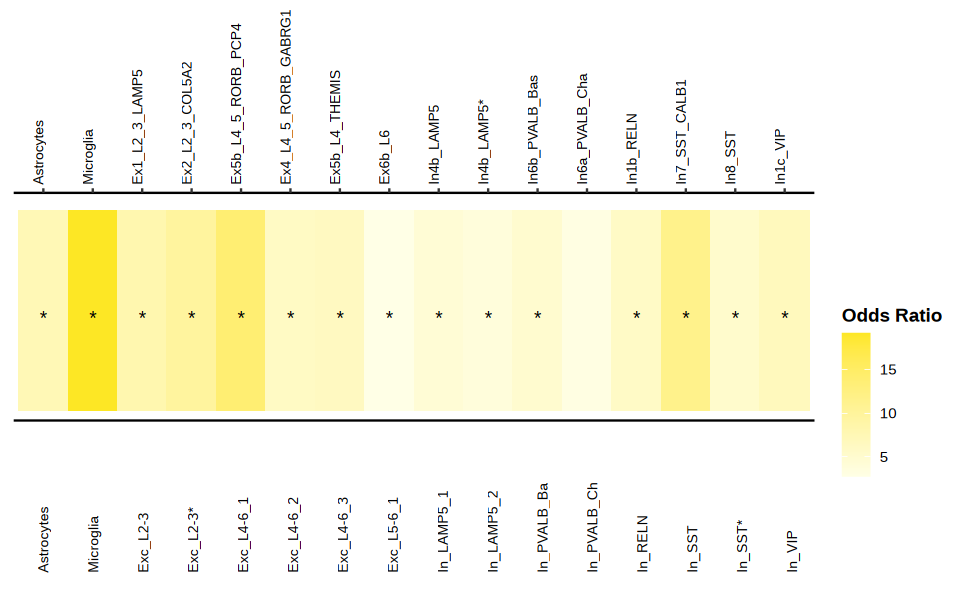

In [25]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(overlap_test_up_table_final, aes(celltype_replication, 1, fill= `Odds Ratio`, label = ifelse(`adj.P.Val` < 0.05, "*", ""))) + 
  geom_tile() + theme_classic() + geom_text(vjust = 1, hjust = 0.5) +
  scale_fill_gradient(low= '#FFFFE6', high='#FDE725') +
  xlab("Cell Types discovery dataset") + theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=0, color="black", 
                                                                          size=8), axis.title.x=element_blank(),
                                               axis.text.y=element_blank(),axis.title.y=element_blank(), 
                                               axis.ticks.y=element_blank(), axis.line.y=element_blank(), 
                                               legend.title = element_text(face='bold')) + scale_x_discrete(position = "top") +
annotate(geom = "text", x = 1.1 + 1.01 * (0:15) , y = -0.31, angle=90, label =overlap_test_up_table_final$celltype_discovery, size = 2.9,
         vjust=0, hjust=0) + geom_hline(yintercept=0.45) 

#ggsave('../figures/celltype_comparison_up_heatmap.pdf', plot = last_plot(), width = 4.5, height =4.5)

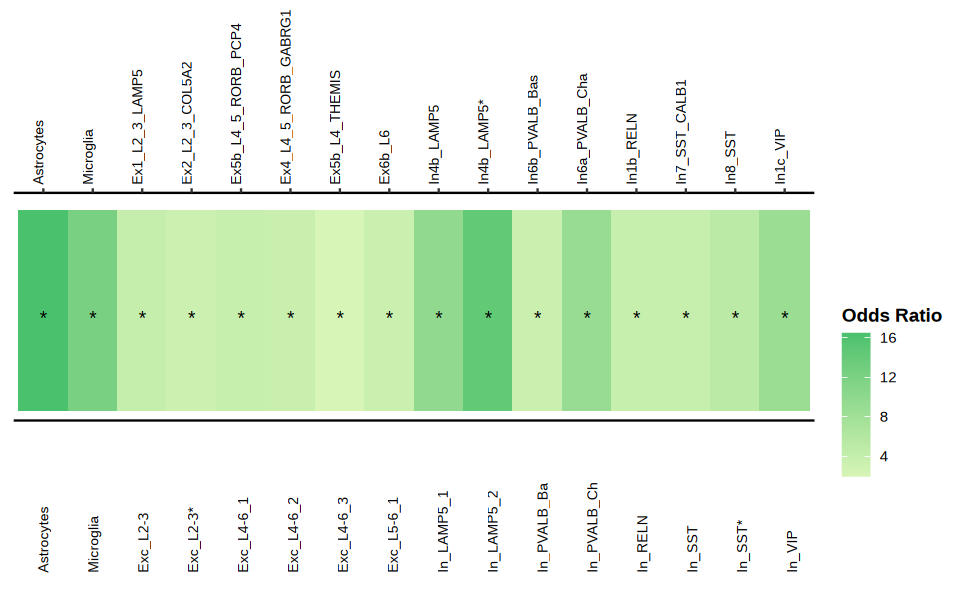

In [26]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(overlap_test_down_table_final, aes(celltype_replication, 1, fill= `Odds Ratio`, label = ifelse(`adj.P.Val` < 0.05, "*", ""))) + 
  geom_tile() + theme_classic() + geom_text(vjust = 1, hjust = 0.5) +
  scale_fill_gradient(low = '#D7F5B7', high= '#4AC16D') +
  xlab("Cell Types discovery dataset") + theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=0, color="black", 
                                                                          size=8), axis.title.x=element_blank(),
                                               axis.text.y=element_blank(),axis.title.y=element_blank(), 
                                               axis.ticks.y=element_blank(), axis.line.y=element_blank(), 
                                               legend.title = element_text(face='bold')) + scale_x_discrete(position = "top") +
annotate(geom = "text", x = 1.1 + 1.01 * (0:15) , y = -0.31, angle=90, label =overlap_test_down_table_final$celltype_discovery, size = 2.9,
         vjust=0, hjust=0) + geom_hline(yintercept=0.45) 

#ggsave('../figures/celltype_comparison_down_heatmap.pdf', plot = last_plot(), width = 4.5, height =4.5)

## logFC correlation

### heatmap

In [27]:
#merge all cell types
discovery_replication_spearman_final <- rbind(astrocytes_spearman, 
                                              microglia_spearman, discovery_replication_spearman)

discovery_replication_spearman_final$adj.P.Val <- p.adjust(discovery_replication_spearman_final$`p-val`, 
                                                           method='fdr', n=length(discovery_replication_spearman_final$`p-val`))


discovery_replication_spearman_final$celltype_discovery <- factor(discovery_replication_spearman_final$celltype_discovery, levels=levels_discovery)
discovery_replication_spearman_final$celltype_replication <- factor(discovery_replication_spearman_final$celltype_replication, levels=levels_replication)

In [28]:
discovery_replication_spearman_final

celltype_discovery,celltype_replication,n_genes,Rho,p-val,adj.P.Val
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
Astrocytes,Astrocytes,20,0.6947368,9.418302e-04,1.004619e-03
Microglia,Microglia,18,0.9153767,0.000000e+00,0.000000e+00
Exc_L2-3,Ex1_L2_3_LAMP5,312,0.7818325,0.000000e+00,0.000000e+00
Exc_L2-3*,Ex2_L2_3_COL5A2,341,0.8070865,0.000000e+00,0.000000e+00
Exc_L4-6_1,Ex5b_L4_5_RORB_PCP4,161,0.8296210,0.000000e+00,0.000000e+00
Exc_L4-6_2,Ex4_L4_5_RORB_GABRG1,199,0.8492188,0.000000e+00,0.000000e+00
Exc_L4-6_3,Ex5b_L4_THEMIS,43,0.8057989,0.000000e+00,0.000000e+00
Exc_L5-6_1,Ex6b_L6,16,0.7235294,2.173821e-03,2.173821e-03
In_LAMP5_1,In4b_LAMP5,71,0.6110329,3.181339e-08,4.241785e-08


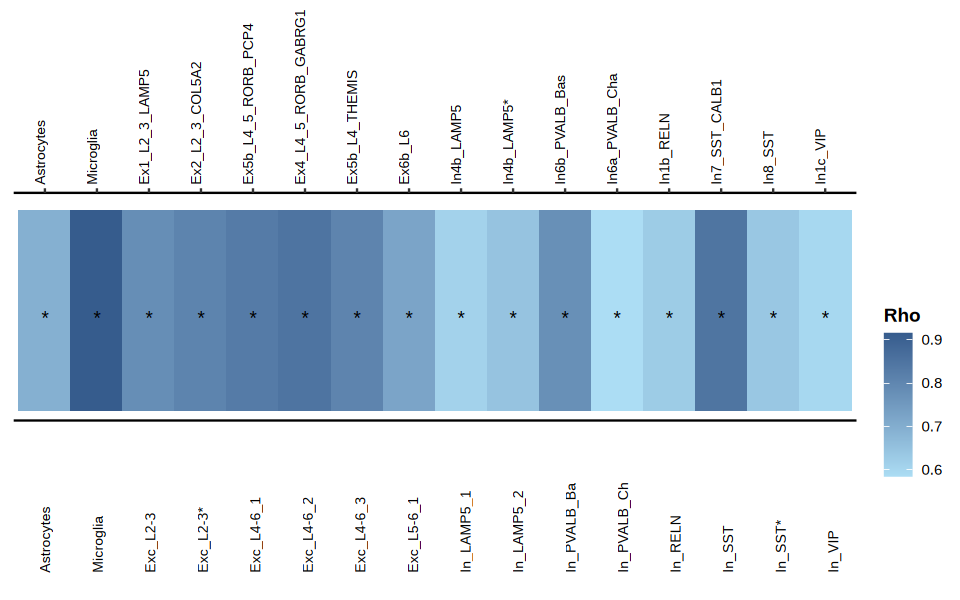

In [29]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(discovery_replication_spearman_final, aes(celltype_replication, 1, fill= `Rho`, label = ifelse(`adj.P.Val` < 0.05, "*", ""))) + 
  geom_tile() + theme_classic() + geom_text(vjust = 1, hjust = 0.5) +
  scale_fill_gradient(low = '#ACDDF4', high= '#365C8D') +
  xlab("Cell Types discovery dataset") + theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=0, color="black", 
                                                                          size=8), axis.title.x=element_blank(),
                                               axis.text.y=element_blank(),axis.title.y=element_blank(), 
                                               axis.ticks.y=element_blank(), axis.line.y=element_blank(), 
                                               legend.title = element_text(face='bold')) + scale_x_discrete(position = "top") +
annotate(geom = "text", x = 1.1 + 1.01 * (0:15) , y = -0.31, angle=90, label =discovery_replication_spearman_final$celltype_discovery , size = 2.9,
         vjust=0, hjust=0) + geom_hline(yintercept=0.45) 

#ggsave('../figures/spearman_corr_discovery_validation_heatmap.pdf', plot = last_plot(), width = 4.175, height =4.5)

# Fig. 5b - scatterplots

In [30]:
Astro_combined <- merge(DE_genes_discovery_sig[['Astrocytes']], Astrocytes, by='ID')[,c(1,2,3,15) ]

colnames(Astro_combined) <- c("genes", "cell type", "logFC.Fröhlich" ,"logFC.Krawczyk")

# add directionality of change up or down or divergent (if directionalities btw datasets do not agree)
Astro_combined$directionality <- NA
Astro_combined[Astro_combined$logFC.Krawczyk >0 &Astro_combined$logFC.Fröhlich >0,]$directionality <- 'up'
Astro_combined[Astro_combined$logFC.Krawczyk <0 &Astro_combined$logFC.Fröhlich <0,]$directionality <- 'down'
Astro_combined$directionality <- factor(Astro_combined$directionality, levels=c('up', 'down'))

head(Astro_combined)

,genes,cell type,logFC.Fröhlich,logFC.Krawczyk,directionality
,<chr>,<chr>,<dbl>,<dbl>,<fct>
1,CAMK4,Astrocytes,-0.024276625,-0.02156334,down
2,CHRDL1,Astrocytes,-0.016427799,-0.02132520,down
3,CISD1,Astrocytes,-0.009032565,-0.02559210,down
4,CSPG5,Astrocytes,-0.017478071,-0.02294819,down
5,DIO2,Astrocytes,-0.019948223,-0.03217303,down
6,DPYSL5,Astrocytes,-0.022302064,-0.05421655,down



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




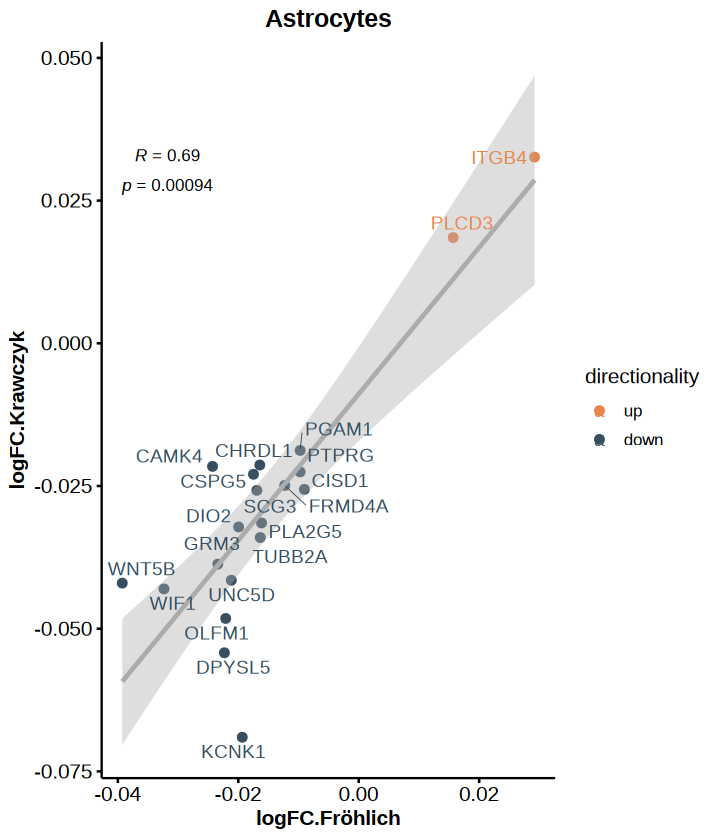

In [31]:
options(ggrepel.max.overlaps = Inf)
options(repr.plot.width=6, repr.plot.height=7)
library(ggpubr)
ggscatter(Astro_combined, x = "logFC.Fröhlich", y = "logFC.Krawczyk", color= 'directionality',
          palette = c("#e9844a", "#374f61"), add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, legend='right', cor.method = "spearman", 
          add.params = list(color = "#acacac", fill = "#acacac"),  xlab = "logFC.Fröhlich", 
          ylab = "logFC.Krawczyk", label = "genes", repel = TRUE, 
          cor.coeff.args = list(label.y = 0.03, label.sep = "\n", size=3.5) ) + ggtitle('Astrocytes') +
theme(axis.title = element_text(face="bold"), legend.position = 'right', plot.title=element_text(face='bold', hjust=0.5))

ggsave('../figures/scatter_Astrocytes_spearman_corr_logFC.pdf', plot = last_plot(), height=5, width = 5)

In [33]:
# filter genes for overlapping ones, select columns of interest and correlate FC changes

Microgloa_Galatro <- rbind(up_Galatro, down_Galatro)[,c(2,5)]
colnames(Microgloa_Galatro)[1] <- 'genes'

combined_microglia <- merge(Microgloa_Galatro, DE_genes_discovery_sig[['Microglia']], by='genes')[,c(1,2,3,4)]
colnames(combined_microglia) <- c("genes", "logFC.Galatro" , "cell type","logFC.Fröhlich")

# add directionality of change up or down or divergent (if directionalities btw datasets do not agree)
combined_microglia$directionality <- NA
combined_microglia[combined_microglia$logFC.Galatro >0 &combined_microglia$logFC.Fröhlich >0,]$directionality <- 'up'
combined_microglia[combined_microglia$logFC.Galatro <0 &combined_microglia$logFC.Fröhlich <0,]$directionality <- 'down'
combined_microglia$directionality <- factor(combined_microglia$directionality, levels=c('up', 'down'))

head(combined_microglia)

,genes,logFC.Galatro,cell type,logFC.Fröhlich,directionality
,<chr>,<dbl>,<chr>,<dbl>,<fct>
1,APBA2,-0.04628862,Microglia,-0.01634402,down
2,ARAP2,0.01698824,Microglia,0.01105381,up
3,BRINP2,-0.03769816,Microglia,-0.02381465,down
4,CECR2,-0.04549836,Microglia,-0.02789304,down
5,DOCK5,0.03983266,Microglia,0.04816156,up
6,FOXP1,0.02208149,Microglia,0.03347958,up


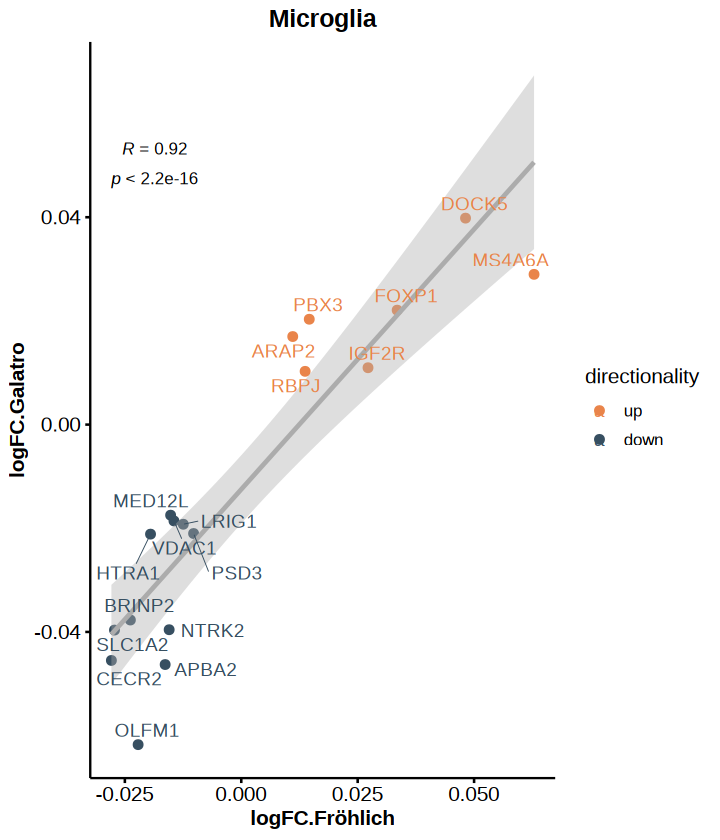

In [34]:
options(ggrepel.max.overlaps = Inf)

ggscatter(combined_microglia, x = "logFC.Fröhlich", y = "logFC.Galatro", color= 'directionality',
          palette = c("#e9844a", "#374f61"), add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, legend='right', cor.method = "spearman", 
          add.params = list(color = "#acacac", fill = "#acacac"),  xlab = "logFC.Fröhlich", 
          ylab = "logFC.Galatro", label = "genes", repel = TRUE, 
          cor.coeff.args = list(label.y = 0.05, label.sep = "\n", size=3.5) ) + ggtitle('Microglia') +
theme(axis.title = element_text(face="bold"), legend.position = 'right', plot.title=element_text(face='bold', hjust=0.5))

ggsave('../figures/scatter_Microglia_spearman_corr_logFC.pdf', plot = last_plot(), height=5, width = 5)

In [35]:
Exc_L4_6_2 <- merge(DE_genes_discovery_sig[['Exc_L4-6_2']], 
                    DE_genes_replication_sig[['Ex4_L4_5_RORB_GABRG1']], by='genes')[,c(1,2,3,10)]
colnames(Exc_L4_6_2) <- c("genes", "cell type", "logFC.Fröhlich" , "logFC.Chatzinakos")

# add directionality of change up or down or divergent (if directionalities btw datasets do not agree)
Exc_L4_6_2$directionality <- NA
Exc_L4_6_2[Exc_L4_6_2$logFC.Chatzinakos >0 &Exc_L4_6_2$logFC.Fröhlich >0,]$directionality <- 'up'
Exc_L4_6_2[Exc_L4_6_2$logFC.Chatzinakos <0 &Exc_L4_6_2$logFC.Fröhlich <0,]$directionality <- 'down'
Exc_L4_6_2[Exc_L4_6_2$logFC.Chatzinakos <0 &Exc_L4_6_2$logFC.Fröhlich >0,]$directionality <- 'div'
Exc_L4_6_2[Exc_L4_6_2$logFC.Chatzinakos >0 &Exc_L4_6_2$logFC.Fröhlich <0,]$directionality <- 'div'
Exc_L4_6_2$directionality <- factor(Exc_L4_6_2$directionality, levels=c('up', 'down', 'div'))
#head(Exc_L4_6_2)

In_LAMP5_2 <- merge(DE_genes_discovery_sig[['In_LAMP5_2']], 
                    DE_genes_replication_sig[['In4b_LAMP5*']], by='genes')[,c(1,2,3,10)]
colnames(In_LAMP5_2) <- c("genes", "cell type", "logFC.Fröhlich" , "logFC.Chatzinakos")
In_LAMP5_2$directionality <- NA
In_LAMP5_2[In_LAMP5_2$logFC.Chatzinakos >0 &In_LAMP5_2$logFC.Fröhlich >0,]$directionality <- 'up'
In_LAMP5_2[In_LAMP5_2$logFC.Chatzinakos <0 &In_LAMP5_2$logFC.Fröhlich <0,]$directionality <- 'down'
#In_LAMP5_2[In_LAMP5_2$logFC.Chatzinakos <0 &In_LAMP5_2$logFC.Fröhlich >0,]$directionality <- 'div'
In_LAMP5_2[In_LAMP5_2$logFC.Chatzinakos >0 &In_LAMP5_2$logFC.Fröhlich <0,]$directionality <- 'div'
In_LAMP5_2$directionality <- factor(In_LAMP5_2$directionality, levels=c('up', 'down', 'div'))
head(In_LAMP5_2)

,genes,cell type,logFC.Fröhlich,logFC.Chatzinakos,directionality
,<chr>,<chr>,<dbl>,<dbl>,<fct>
1,ACTB,In_LAMP5_2,-0.01498964,-0.03640083,down
2,ACTG1,In_LAMP5_2,-0.01545861,-0.04334302,down
3,AP2M1,In_LAMP5_2,-0.01378526,-0.03758738,down
4,ARL4C,In_LAMP5_2,-0.01526769,-0.02799276,down
5,ARL6IP4,In_LAMP5_2,-0.01571829,-0.03675665,down
6,ARL6IP5,In_LAMP5_2,-0.01147328,-0.03184374,down


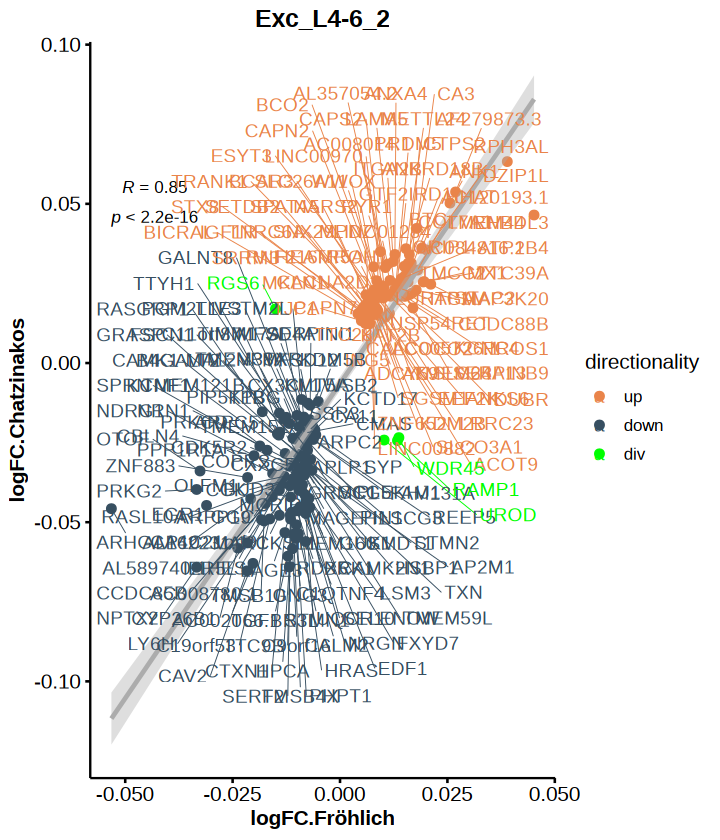

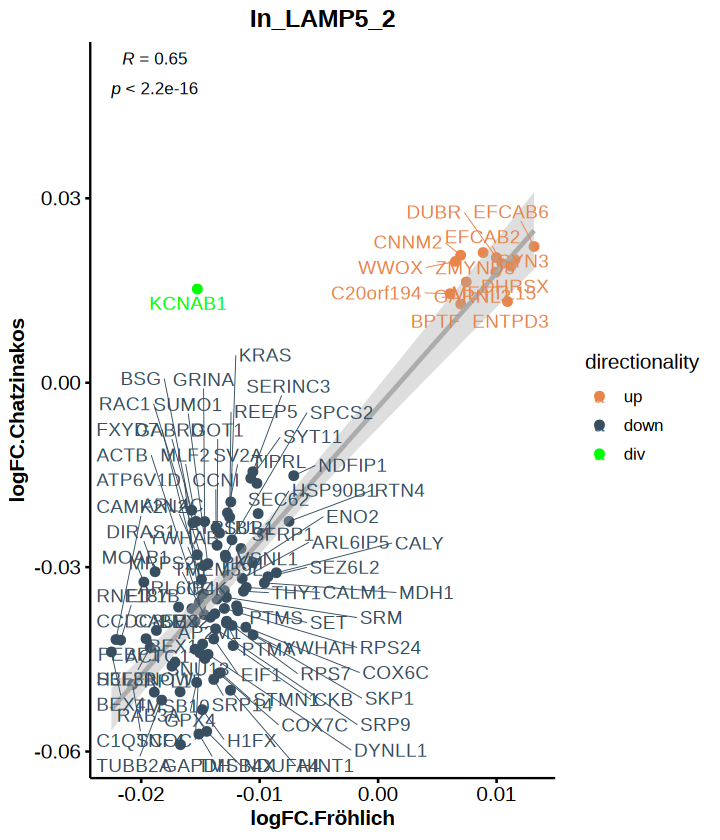

In [36]:
options(ggrepel.max.overlaps = Inf)

ggscatter(Exc_L4_6_2, x = "logFC.Fröhlich", y = "logFC.Chatzinakos", color= 'directionality',
          palette = c("#e9844a", "#374f61", 'green'), add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, legend='right', cor.method = "spearman", 
          add.params = list(color = "#acacac", fill = "#acacac"),  xlab = "logFC.Fröhlich", 
          ylab = "logFC.Chatzinakos", label = "genes", repel = TRUE, 
          cor.coeff.args = list(label.y = 0.05, label.sep = "\n", size=3.5) ) + ggtitle('Exc_L4-6_2') +
theme(axis.title = element_text(face="bold"), legend.position = 'right', plot.title=element_text(face='bold', hjust=0.5))

ggscatter(In_LAMP5_2, x = "logFC.Fröhlich", y = "logFC.Chatzinakos", color= 'directionality',
          palette = c("#e9844a", "#374f61", 'green'), add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, legend='right', cor.method = "spearman", 
          add.params = list(color = "#acacac", fill = "#acacac"),  xlab = "logFC.Fröhlich", 
          ylab = "logFC.Chatzinakos", label = "genes", repel = TRUE, 
          cor.coeff.args = list(label.y = 0.05, label.sep = "\n", size=3.5) ) + ggtitle('In_LAMP5_2') +
theme(axis.title = element_text(face="bold"), legend.position = 'right', plot.title=element_text(face='bold', hjust=0.5))


# SessionInfo

In [37]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggpubr_0.6.0       GeneOverlap_1.38.0 viridis_0.6.4      viridisLite_0.4.2 
 [5] qvalue_2.34.0      cowplot_1.1.1      readxl_1.4.3       lubridate_1.9.3   
 [9] forcats_1.0.0      stringr_1.5.1      dplyr_